In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt

def get_random_map(n, nside=64, dec_min=10., dec_max=70.,
                   ra_min=0., ra_max=360., weights = False):
    """ Generates and returns a map of resolution `nside`
    with `n` randomly positioned points between declinations
    `dec_min` and `dec_max` and right ascensions `ra_min`
    and `ra_max`. Each pixel in the returned map contains
    the number of points falling inside it.
    """
    # Generate cos(theta) and phi
    npix = hp.nside2npix(nside)
    cthmin = np.cos(np.radians(90-dec_min))
    cthmax = np.cos(np.radians(90-dec_max))
    cth = cthmin + (cthmax-cthmin)*np.random.rand(n)
    th = np.arccos(cth)
    ph = np.radians(ra_min + (ra_max-ra_min)*np.random.rand(n))
    # Weights 
    w = np.random.random(n)
    # HEALPix pixel indices
    ipix = hp.ang2pix(nside, th, ph)
    # Number counts map
    if weights:
        nmap = np.bincount(ipix, w, minlength=npix)
    else:
        nmap = np.bincount(ipix, minlength=npix)
    
    return nmap.astype(float), w

def get_delta_mask(nmap_d, nmap_r, w_d, w_r, weights ):
    """Given two number count maps `nmap_d` (corresponding
    to the data) and `nmap_r` (corresponding to the random),
    this returns the estimated overdensity map, the estimated
    mean number of points for the data from the randoms
    (i.e. the map to be used as mask in the C_ell estimator),
    and the estimated coupled noise bias.
    """
    # R/D ratio
    alpha = np.sum(nmap_d)/np.sum(nmap_r)
    # Non-empty pixels
    goodpix = nmap_r > 0
    # Overdensity
    delta = np.zeros_like(nmap_d)
    delta[goodpix] = nmap_d[goodpix]/(alpha*nmap_r[goodpix]) - 1
    # Coupled analytical noise bias
    a_pix = 4*np.pi / len(nmap_d)
    if weights:
        nl_coupled = (np.sum(w_d**2) + alpha**2*np.sum(w_r**2))*a_pix**2/(4*np.pi)
    else:
        nl_coupled = (np.sum(nmap_d) + alpha**2*np.sum(nmap_r))*a_pix**2/(4*np.pi)
    
    return delta, nmap_r*alpha, nl_coupled

# Number of simulations to average over
nsims = 100
# Resolution
nside = 64
# Number of data points
ndat = 40000
# Number of random points
nran = 50 * ndat

# Bandpowers
b = nmt.NmtBin(nside, nlb=10)

# Power spectrum wrapping
def cl(f):
    """For a given NmtField, estimates the
    power spectrum.
    """
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f, f, b)
    return w.decouple_cell(nmt.compute_coupled_cell(f, f))[0], w

# Generate simulation and compute all relevant power spectra
def run_sim(plot_stuff=False, add_weights = False):
    """This function:
    1. Generates two sets of data-random maps.
    2. Computes its associated difference map.
    3. Transforms all those into NmtFields.
    4. Estimates the associated power spectra.
    5. Estimates the associated analytical noise biases.
    Returns:
    cl1 : power spectrum of the first set of maps.
    cl2 : power spectrum of the second set of maps.
    cl12 : power spectrum of the difference map.
    nl1 : analytical noise bias for the first map.
    nl2 : analytical noise bias for the second map.
    """
    # First maps
    map1_d, w1_d = get_random_map(ndat, nside, weights=add_weights)
    map1_r, w1_r = get_random_map(nran, nside, weights=add_weights)
    d1, m1, nl1  = get_delta_mask(map1_d, map1_r, w1_d, w1_r, weights=add_weights)
    # Second maps
    map2_d, w2_d = get_random_map(ndat, nside, weights=add_weights)
    map2_r, w2_r = get_random_map(nran, nside, weights=add_weights)
    d2, m2, nl2  = get_delta_mask(map2_d, map2_r, w2_d, w2_r, weights=add_weights)
    
    # Difference map and associated (wrong) mask
    d12 = (d1 - d2)/np.sqrt(2)
    m12 = 0.5*(m1+m2)
    if plot_stuff:
        hp.mollview(d1)
        hp.mollview(d2)
        hp.mollview(d12)
        plt.show()
    # Transform into fields
    f1 = nmt.NmtField(m1, [d1], n_iter=0)
    f2 = nmt.NmtField(m2, [d2], n_iter=0)
    f12 = nmt.NmtField(m12, [d12], n_iter=0)
    f12_alt1 = nmt.NmtField(m1, [d12], n_iter=0)
    f12_alt2 = nmt.NmtField(m2, [d12], n_iter=0)
    # Compute C_ells
    cl1, w1 = cl(f1)
    cl2, w2 = cl(f2)
    cl12, w12 = cl(f12)
    cl12_alt1, w12_alt1 = cl(f12_alt1)
    cl12_alt2, w12_alt2 = cl(f12_alt2)
    # Compute analytical N_ells
    nl1 = w1.decouple_cell([np.ones(3*nside)*nl1])[0]
    nl2 = w1.decouple_cell([np.ones(3*nside)*nl2])[0]
    return cl1, cl2, cl12,  cl12_alt1, cl12_alt2, nl1, nl2

In [2]:
# Loop over sims collecting the power spectra of all
# of them
cl1s, cl2s, cl12s, cl12_alt1s, cl12_alt2s, nl1s, nl2s = [], [], [], [], [], [], []
for i in range(nsims):
    cl1, cl2, cl12, cl12_alt1, cl12_alt2, nl1, nl2 = run_sim(add_weights=False)
    cl1s.append(cl1)
    cl2s.append(cl2)
    nl1s.append(nl1)
    nl2s.append(nl2)
    cl12s.append(cl12)
    cl12_alt1s.append(cl12_alt1)
    cl12_alt2s.append(cl12_alt2)
    
# Average over sims
cl1m = np.mean(np.array(cl1s), axis=0)
cl2m = np.mean(np.array(cl2s), axis=0)
nl1m = np.mean(np.array(nl1s), axis=0)
nl2m = np.mean(np.array(nl2s), axis=0)
cl12m = np.mean(np.array(cl12s), axis=0)
cl12_alt1m = np.mean(np.array(cl12_alt1s), axis=0)
cl12_alt2m = np.mean(np.array(cl12_alt2s), axis=0)


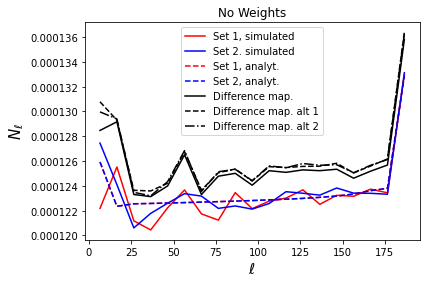

In [3]:
# Plot results
leff = b.get_effective_ells()

plt.plot(leff, cl1m, 'r-', label='Set 1, simulated')
plt.plot(leff, cl2m, 'b-', label='Set 2. simulated')
plt.plot(leff, nl1m, 'r--', label='Set 1, analyt.')
plt.plot(leff, nl2m, 'b--', label='Set 2, analyt.')
plt.plot(leff, cl12m, 'k-', label='Difference map.')
plt.plot(leff, cl12_alt1m, 'k--', label='Difference map. alt 1')
plt.plot(leff, cl12_alt2m, 'k-.', label='Difference map. alt 2')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$N_\ell$', fontsize=15)
plt.title('No Weights')
plt.legend()
plt.show()

In [6]:
# Loop over sims collecting the power spectra of all
# of them
cl1s, cl2s, cl12s, cl12_alt1s, cl12_alt2s, nl1s, nl2s = [], [], [], [], [], [], []
for i in range(nsims):
    cl1, cl2, cl12, cl12_alt1, cl12_alt2, nl1, nl2 = run_sim(add_weights=True)
    cl1s.append(cl1)
    cl2s.append(cl2)
    nl1s.append(nl1)
    nl2s.append(nl2)
    cl12s.append(cl12)
    cl12_alt1s.append(cl12_alt1)
    cl12_alt2s.append(cl12_alt2)
    
# Average over sims
cl1m = np.mean(np.array(cl1s), axis=0)
cl2m = np.mean(np.array(cl2s), axis=0)
nl1m = np.mean(np.array(nl1s), axis=0)
nl2m = np.mean(np.array(nl2s), axis=0)
cl12m = np.mean(np.array(cl12s), axis=0)
cl12_alt1m = np.mean(np.array(cl12_alt1s), axis=0)
cl12_alt2m = np.mean(np.array(cl12_alt2s), axis=0)



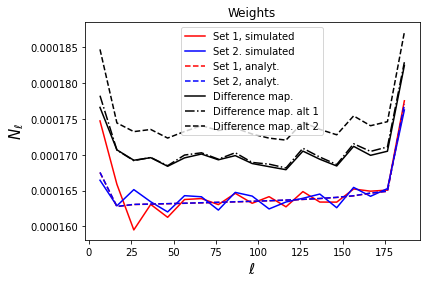

In [7]:
# Plot results
leff = b.get_effective_ells()

plt.plot(leff, cl1m, 'r-', label='Set 1, simulated')
plt.plot(leff, cl2m, 'b-', label='Set 2. simulated')
plt.plot(leff, nl1m, 'r--', label='Set 1, analyt.')
plt.plot(leff, nl2m, 'b--', label='Set 2, analyt.')
plt.plot(leff, cl12m, 'k-', label='Difference map.')
plt.plot(leff, cl12_alt1m, 'k-.', label='Difference map. alt 1')
plt.plot(leff, cl12_alt2m, 'k--', label='Difference map. alt 2')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$N_\ell$', fontsize=15)
plt.title('Weights')
plt.legend()
plt.show()